In [1]:
# coding:utf8
import numpy as np
from math import pi
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, show
from bokeh.layouts import gridplot
from bokeh.models import LinearAxis, LogAxis, Range1d
from scipy.fftpack import fft, fftfreq, fftshift, rfft
output_file('Fourier.html')
%matplotlib notebook

In [2]:
tick = pd.read_csv('RIM6_4.trd', usecols=(0, 1, 2, 3, 4, 5, 6),
                   parse_dates={'DateTime': [0,1]}, index_col=False)

In [3]:
tick = tick.rename(columns={'<LAST>': 'Price', '<VOL>': 'Vol', '<DIRECTION>': 'Dir'})

In [4]:
tick.ix[tick.Dir == 'Sell', 'VolSell'] = tick.Vol

In [5]:
tick.ix[tick.Dir == 'Buy', 'VolBuy'] = tick.Vol

In [6]:
Nticks = 500     # Количество тиков для бара и ресэмплинг по тикам
TimeRes = '60s'  # Интервал ресэмплинга в секундах
dt = 60          # Interval FFT
fs = 1.0/dt        # Sampling frequency
fs, dt

(0.016666666666666666, 60)

In [7]:
ml = tick.set_index('DateTime').Price.resample(TimeRes).ohlc()
ml['VolBuy'] = tick.set_index('DateTime').VolBuy.resample(TimeRes).sum()
ml['VolSell'] = tick.set_index('DateTime').VolSell.resample(TimeRes).sum()
ml['TickBuy'] = tick.set_index('DateTime').VolBuy.resample(TimeRes).count()
ml['TickSell'] = tick.set_index('DateTime').VolSell.resample(TimeRes).count()
ml['OTON'] = ((ml['TickBuy']*ml['VolBuy']-ml['TickSell']*ml['VolSell']) /
              (ml['TickBuy']*ml['VolBuy']+ml['TickSell']*ml['VolSell']))
pd.DataFrame.to_csv(ml, path_or_buf='ml.csv')
# #ml[-64:]

In [9]:
L = len(ml[-64:])
t = np.linspace(0, L, num=64)
plt.plot(t, ml[-64:].OTON)

out = fft(ml[-64:].OTON, L) / L
len(out)

64

<IPython.core.display.Javascript object>


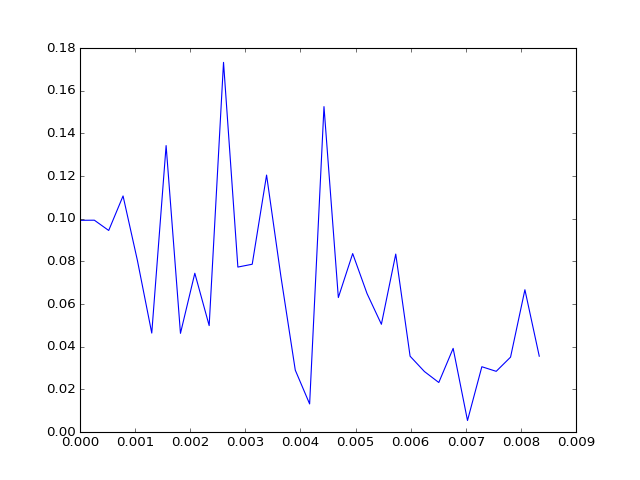

In [26]:
#len(np.linspace(0, 1, num=(len(out)/2 + 1)))
#len(out[0:(len(out)/2 + 1)])
#fs/2*np.linspace(0, 1, num=(len(out)/2 + 1))
#np.absolute(out[0:(len(out)/2 + 1)])
plt.plot(fs/2*np.linspace(0, 1, num=(len(out)/2 + 1)), np.absolute(out[0:(len(out)/2 + 1)]))

In [7]:
rows_list=[]
for i in range(0, len(tick.index), Nticks):
    dict1 = {}
    op = tick.Price.iloc[i]
    hi = tick.Price.iloc[i:i+Nticks].max()
    lo = tick.Price.iloc[i:i+Nticks].min()
    if i+Nticks < len(tick.index):
        cl = tick.loc[i+Nticks-1].Price
    else:
        cl = tick.loc[len(tick.index)-1].Price
    
    vBuy = tick.VolBuy.iloc[i:i+Nticks].sum()
    vSell = tick.VolSell.iloc[i:i+Nticks].sum()
    nBuy = tick.VolBuy.iloc[i:i+Nticks].count()
    nSell = tick.VolSell.iloc[i:i+Nticks].count()
    tClose = tick.DateTime.iloc[i:i+Nticks].max()
    dtime = tick.DateTime.iloc[i:i+Nticks].max()-tick.DateTime.iloc[i:i+Nticks].min()
    dict1.update({'DateTime': tClose, 'open': op, 'high': hi,
                  'low': lo, 'close': cl, 'TickBuy': nBuy,
                  'VolBuy': vBuy, 'TickSell': nSell, 'VolSell': vSell, 'DeltaTime': dtime})
    rows_list.append(dict1)
    
res = pd.DataFrame(rows_list)
res['Dsec'] = res['DeltaTime'].dt.total_seconds()
res['TSpeedBuy'] = res['TickBuy']/res['Dsec']
res['TSpeedSell'] = res['TickSell']/res['Dsec']
res['VSpeedBuy'] = res['VolBuy']/res['Dsec']
res['VSpeedSell'] = res['VolSell']/res['Dsec']
res['OTO'] = ((res['TickBuy']-res['TickSell'])/(res['TickBuy']+res['TickSell'])*0.65
              + (res['VolBuy']-res['VolSell'])/(res['VolBuy']+res['VolSell'])*0.35)*100.0
res['OTON'] = ((res['TickBuy']*res['VolBuy']-res['TickSell']*res['VolSell'])/
               (res['TickBuy']*res['VolBuy']+res['TickSell']*res['VolSell']))*100.0
res['Delta'] = res['VolBuy']-res['VolSell']
res['CumDelta'] = res['Delta'].cumsum()

In [12]:
#res

In [13]:
# res = res.set_index('DateTime')
mids = (res.open + res.close)/2
spans = abs(res.close - res.open)
inc = res.close > res.open
dec = res.open > res.close
#w = 12*60*60
w = 0.5

In [14]:
p = figure(x_range=(0, len(res.index)), plot_width=800, plot_height=600, title='RIM6 CandleStick')
p.y_range=Range1d(start=90500, end=95000)
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha = 0.3
p.segment(res.index.values, res.high, res.index.values, res.low, color='black')
p.rect(res.index[inc], mids[inc], w, spans[inc], fill_color='#6CF350', line_color='green')
p.rect(res.index[dec], mids[dec], w, spans[dec], fill_color='#FF0000', line_color='red')
p.extra_y_ranges = {}
p.extra_y_ranges['TickSpeed'] = Range1d(start=0, end=100)
p.extra_y_ranges['OTO'] = Range1d(start=-60, end=60)
p.extra_y_ranges['OTON'] = Range1d(start=-60, end=60)
p.extra_y_ranges['CumDelta'] = Range1d(start=-3000, end=52000)
#p.line(res.index, res.TSpeedBuy, color='blue', y_range_name='TickSpeed', alpha=0.5)
p.line(res.index, res.TSpeedBuy.rolling(window=4).median(), color='green', y_range_name='TickSpeed', alpha=0.8)
#p.line(res.index, res.TSpeedSell, color='red', y_range_name='TickSpeed', alpha=0.5)
p.line(res.index, res.TSpeedSell.rolling(window=9).median(), color='red', y_range_name='TickSpeed', alpha=0.8)
p.line(res.index, res.OTO.rolling(window=15).mean(), color='brown', y_range_name='OTO', alpha=0.9)
p.line(res.index, res.OTON.rolling(window=15).mean(), color='blue', y_range_name='OTON', alpha=0.9)
p.line(res.index, res.CumDelta, color='black', y_range_name='CumDelta', alpha=0.9)
p.add_layout(LogAxis(y_range_name='TickSpeed'), 'left')
p.add_layout(LinearAxis(y_range_name='OTO'), 'left')
p.add_layout(LinearAxis(y_range_name='OTON'), 'left')
p.add_layout(LinearAxis(y_range_name='CumDelta'), 'left')
#show(p)
l=figure(plot_width=800, plot_height=600, title='FFT')
l.line(resfftfreq, resfft)
m = gridplot([[p, l]])

show(m)

In [ ]:
# plt.plot(fs/2*np.linspace(0, 1, num=(len(out)/2 + 1)), np.absolute(out[1:(len(out)/2 + 1)])
#len(np.absolute(out[1:(len(out)/2 + 1)]))